<a href="https://colab.research.google.com/github/MohuaSinha/EIP4/blob/master/S7/S7_Solution_Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd "//content/gdrive/My Drive/Colab Notebooks/EVA4/Session 7"
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 7'
sys.path.append(workingdir)

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session 7


In [3]:
ls-ltr

total 89
-rw------- 1 root root 19259 Mar  6 12:57 S7_AllFunctions.ipynb
drwx------ 3 root root  4096 Mar  7 12:33 data/
-rw------- 1 root root  1076 Mar  7 12:57 displayimages.ipynb
-rw------- 1 root root  3320 Mar  7 13:23 datatransformation.ipynb
-rw------- 1 root root  3875 Mar  7 13:33 dnnmodel_old.ipynb
-rw------- 1 root root  5869 Mar  7 13:34 dnnmodel.ipynb
-rw------- 1 root root  3969 Mar  7 13:49 train_test.ipynb
-rw------- 1 root root 44018 Mar  7 14:09 S7_Solution_Main.ipynb
-rw------- 1 root root  3379 Mar  7 14:15 showimages.ipynb



Training a Classifier
=====================

This is it. You have seen how to define neural networks, compute loss and make
updates to the weights of the network.

Now you might be thinking,

What about data?
----------------

Generally, when you have to deal with image, text, audio or video data,
you can use standard python packages that load data into a numpy array.
Then you can convert this array into a ``torch.*Tensor``.

-  For images, packages such as Pillow, OpenCV are useful
-  For audio, packages such as scipy and librosa
-  For text, either raw Python or Cython based loading, or NLTK and
   SpaCy are useful

Specifically for vision, we have created a package called
``torchvision``, that has data loaders for common datasets such as
Imagenet, CIFAR10, MNIST, etc. and data transformers for images, viz.,
``torchvision.datasets`` and ``torch.utils.data.DataLoader``.

This provides a huge convenience and avoids writing boilerplate code.

For this tutorial, we will use the CIFAR10 dataset.
It has the classes: ‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’,
‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’. The images in CIFAR-10 are of
size 3x32x32, i.e. 3-channel color images of 32x32 pixels in size.

.. figure:: /_static/img/cifar10.png
   :alt: cifar10

   cifar10


Training an image classifier
----------------------------

We will do the following steps in order:

1. Load and normalizing the CIFAR10 training and test datasets using
   ``torchvision``
2. Define a Convolution Neural Network
3. Define a loss function
4. Train the network on the training data
5. Test the network on the test data

1. Loading and normalizing CIFAR10
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Using ``torchvision``, it’s extremely easy to load CIFAR10.



In [4]:
!pip install import-ipynb
import import_ipynb
#from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
!pip install torchsummary
from torchsummary import summary
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
import os

#Below are the created modules
import dnnmodel 
import train_test
import datatransformation 
import showimages
import displayimages
from torch.optim.lr_scheduler import StepLR

importing Jupyter notebook from dnnmodel.ipynb
importing Jupyter notebook from train_test.ipynb
importing Jupyter notebook from datatransformation.ipynb
importing Jupyter notebook from showimages.ipynb
importing Jupyter notebook from displayimages.ipynb


The output of torchvision datasets are PILImage images of range [0, 1].
We transform them to Tensors of normalized range [-1, 1].



In [0]:
train_transforms,test_transforms= datatransformation.load()

In [6]:
classes,trainloader, testloader = datatransformation.dataloaders(1, 128, 10, train_transforms , test_transforms)

CUDA Available? True
Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


shape: torch.Size([128, 3, 32, 32])
  cat truck truck   cat   cat


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe


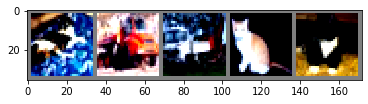

In [7]:
displayimages.show_random_image(trainloader,classes)

2. Define a Convolution Neural Network
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Copy the neural network from the Neural Networks section before and modify it to
take 3-channel images (instead of 1-channel images as it was defined).



In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = dnnmodel.Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 64, 32, 32]          18,432
              ReLU-5           [-1, 64, 32, 32]               0
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7          [-1, 128, 32, 32]          73,728
              ReLU-8          [-1, 128, 32, 32]               0
       BatchNorm2d-9          [-1, 128, 32, 32]             256
           Conv2d-10           [-1, 32, 32, 32]           4,096
        MaxPool2d-11           [-1, 32, 16, 16]               0
           Conv2d-12           [-1, 64, 16, 16]          18,432
             ReLU-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1

In [0]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [10]:
EPOCHS =10 
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_test.train(model, device, trainloader, optimizer, epoch,False)
    train_test.test(model, device, testloader)

  0%|          | 0/391 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.8404707908630371 Batch_id=390 Accuracy=52.97: 100%|██████████| 391/391 [00:17<00:00, 22.93it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 1.1706, Accuracy: 5874/10000 (58.74%)

EPOCH: 1


Loss=0.8696250915527344 Batch_id=390 Accuracy=70.44: 100%|██████████| 391/391 [00:16<00:00, 32.55it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.8301, Accuracy: 7078/10000 (70.78%)

EPOCH: 2


Loss=0.6553795337677002 Batch_id=390 Accuracy=76.62: 100%|██████████| 391/391 [00:17<00:00, 22.75it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7070, Accuracy: 7548/10000 (75.48%)

EPOCH: 3


Loss=0.5805972218513489 Batch_id=390 Accuracy=80.23: 100%|██████████| 391/391 [00:17<00:00, 22.72it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.7032, Accuracy: 7524/10000 (75.24%)

EPOCH: 4


Loss=0.44070759415626526 Batch_id=390 Accuracy=82.61: 100%|██████████| 391/391 [00:17<00:00, 22.60it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6098, Accuracy: 7925/10000 (79.25%)

EPOCH: 5


Loss=0.4578050673007965 Batch_id=390 Accuracy=84.93: 100%|██████████| 391/391 [00:17<00:00, 33.04it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6007, Accuracy: 7938/10000 (79.38%)

EPOCH: 6


Loss=0.38823509216308594 Batch_id=390 Accuracy=86.46: 100%|██████████| 391/391 [00:17<00:00, 33.40it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.5987, Accuracy: 7958/10000 (79.58%)

EPOCH: 7


Loss=0.39383959770202637 Batch_id=390 Accuracy=88.25: 100%|██████████| 391/391 [00:17<00:00, 22.70it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6224, Accuracy: 8010/10000 (80.10%)

EPOCH: 8


Loss=0.4409962594509125 Batch_id=390 Accuracy=89.48: 100%|██████████| 391/391 [00:17<00:00, 22.81it/s]
  0%|          | 0/391 [00:00<?, ?it/s]


Test set: Average loss: 0.6340, Accuracy: 7973/10000 (79.73%)

EPOCH: 9


Loss=0.2874799370765686 Batch_id=390 Accuracy=90.82: 100%|██████████| 391/391 [00:17<00:00, 22.84it/s]



Test set: Average loss: 0.5810, Accuracy: 8128/10000 (81.28%)



3. Define a Loss function and optimizer
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
Let's use a Classification Cross-Entropy loss and SGD with momentum.



4. Train the network
^^^^^^^^^^^^^^^^^^^^

This is when things start to get interesting.
We simply have to loop over our data iterator, and feed the inputs to the
network and optimize.



5. Test the network on the test data
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

We have trained the network for 2 passes over the training dataset.
But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network
outputs, and checking it against the ground-truth. If the prediction is
correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


GroundTruth:  plane   car  ship plane   car
Predicted:  plane   car  ship plane   car


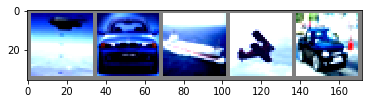

In [11]:
showimages.show_predicted_actual(model, device, testloader, classes)

Okay, now let us see what the neural network thinks these examples above are:



The outputs are energies for the 10 classes.
Higher the energy for a class, the more the network
thinks that the image is of the particular class.
So, let's get the index of the highest energy:



The results seem pretty good.

Let us look at how the network performs on the whole dataset.



In [13]:
showimages.evaluate_accuracy(model, device, testloader)

Accuracy of the network on the 10000 test images: 81 %


That looks waaay better than chance, which is 10% accuracy (randomly picking
a class out of 10 classes).
Seems like the network learnt something.

Hmmm, what are the classes that performed well, and the classes that did
not perform well:



In [14]:
showimages.evaluate_classwise_accuracy(model, device, classes, testloader)

Accuracy of plane : 79 %
Accuracy of   car : 94 %
Accuracy of  bird : 87 %
Accuracy of   cat : 44 %
Accuracy of  deer : 71 %
Accuracy of   dog : 76 %
Accuracy of  frog : 89 %
Accuracy of horse : 96 %
Accuracy of  ship : 92 %
Accuracy of truck : 85 %
